In [1]:
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import noisereduce
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display
import torch
import torchaudio
import torchaudio.transforms as transforms
import torchaudio.functional as F

from PIL import Image
import skimage.io
import cv2


directory = '../spectrograms/'

def extract_from_filename(filename):
    filename = filename.replace('.wav', '')
    parts = filename.split('_')
    print(parts)
    speaker_id = parts[0]
    gender = 'female' if speaker_id[0] == 'f' else 'male'
    script_id = parts[1]
    if len(parts) > 3 and not parts[3][0].isdigit():
        recording_type = '_'.join(parts[2:4])
    else:
        recording_type = parts[2]
    return speaker_id, script_id, gender, recording_type
#TODO why second empty
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    print(plt.subplots(num_channels, 1))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        # axes[c].set_xlim([0, 30])
    figure.suptitle("waveform")

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        # axes[c].set_xlim([0, 15])
        # axes[c].set_ylim([0, 1500])
    figure.suptitle(title)        

class_one = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']
data = []

# for filename in os.listdir(directory):
#     if filename.startswith('.'):
#         continue
#     if filename.endswith('.png'):
#         filepath = os.path.join(directory, filename)
        
#         try:
#             speaker_id, script_id = extract_from_filename(filename)
#             # samples = waveform.numpy().flatten()

#             is_class_one = any(s in filepath for s in class_one)

#             img = cv2.imread(filepath)
#             gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
            
#             plt.plot(hist)
#             # label the x-axis
#             plt.xlabel('Pixel Intensity')
#             # label the y-axis
#             plt.ylabel('Number of Pixels')
#             # display the title
#             plt.title('Grayscale Histogram')
            
#             plt.show()
            

#             # dest1 = '../sliced_spectograms/1'
#             # dest2 = '../sliced_spectograms/0'

#             # if is_class_one:
#             #     os.rename(filepath,os.path.join(dest1,filename))
#             # else:
#             #     os.rename(filepath,os.path.join(dest2,filename))
            
#             # duration = waveform.shape[1] / sample_rate
#             # rms_energy = np.sqrt(np.mean(samples**2))
#             # zcr = librosa.feature.zero_crossing_rate(samples)[0].mean()
#             # spectral_centroid = librosa.feature.spectral_centroid(y=samples, sr=sample_rate)[0].mean()
#             # spectral_bandwidth = librosa.feature.spectral_bandwidth(y=samples, sr=sample_rate)[0].mean()
#             # mfccs = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=13).mean(axis=1)
            
#             # frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
#             # mean_spectrogram = np.mean(spectrogram)
#             # std_spectrogram = np.std(spectrogram)
            
#             # dominant_freq = frequencies[np.argmax(spectrogram, axis=0)].mean()
    
#             # data.append({
#             #     'filename': filename,
#             #     'speaker_id': speaker_id,
#             #     'script_id': script_id,
#             #     'audio_type': audio_type,
#             #     'duration': duration,
#             #     'sample_rate': sample_rate,
#             #     'rms_energy': rms_energy,
#             #     'zero_crossing_rate': zcr,
#             #     'spectral_centroid': spectral_centroid,
#             #     'spectral_bandwidth': spectral_bandwidth,
#             #     'mfccs': mfccs.tolist(),
#             #     'mean_spectrogram': mean_spectrogram,
#             #     'std_spectrogram': std_spectrogram,
#             #     'dominant_freq': dominant_freq
#             # })
#             #print(data)

#             # plot_waveform(waveformt, sr)
#             # plt.show()
#             # plot_specgram(waveformt, sr)
#             # plt.show()
            
#         except ValueError as e:
#             print(f"Error reading {filename}: {e}")
#         except Exception as e:
#             print(f"An unexpected error occurred with {filename}: {e}")

# #df = pd.DataFrame(data)




KeyboardInterrupt: 

In [11]:
import noisereduce

directories = [
    '../audio/0',
    '../audio/1'
]

def create_metadata_df(directories):
    data = []
    for directory in directories:
        for filename in os.listdir(directory):
                
            speaker_id, script_id, gender, recording_type = extract_from_filename(filename)
            filepath = os.path.join(directory,filename)
            y, sr = librosa.load(filepath,sr=None)
            y=noisereduce.reduce_noise(y=y,sr=sr) # reducing noise, without it almost all audio is considered speech with based top_db being 60
            duration = librosa.get_duration(y=y, sr=sr)
            db = librosa.amplitude_to_db(y)
            # print(np.max(abs(db))) #around 80
    
            # non_silent_intervals = librosa.effects.split(y)
        
            # Calculate the talking duration
            # talking_duration = sum((end - start) / sr for start, end in non_silent_intervals)   
            # silence_duration = duration - talking_duration
    
                # Compute RMSE (Root Mean Square Energy)
            rmse = librosa.feature.rms(y=y).mean()  # Mean RMSE across frames
            
            # Compute ZCR (Zero Crossing Rate)
            zcr = librosa.feature.zero_crossing_rate(y).mean()  # Mean ZCR across frames
            
            data.append({
                'filename': filename,
                'speaker_id': speaker_id,
                'gender': gender,
                'script_id': script_id,
                'recording_type': recording_type,
                'is_class_one': any(s in filename for s in class_one),
                'path': filepath,
                'duration': duration,
                # 'talking_duration': talking_duration,
                # 'silence_duration': silence_duration,
                'RMSE': rmse,
                'ZCR': zcr,
            })
    return pd.DataFrame(data)

metadata_df = create_metadata_df(directories)
print(metadata_df.head())

['m5', 'script2', 'clean']
['m7', 'script3', 'clean']
['f3', 'script2', 'clean']
['m4', 'script4', 'clean']
['f2', 'script4', 'clean']
['f4', 'script3', 'clean']
['m2', 'script3', 'clean']
['f6', 'script2', 'clean']
['f5', 'script5', 'clean']
['m1', 'script4', 'clean']
['m4', 'script2', 'clean']
['m10', 'script1', 'clean']
['f2', 'script2', 'clean']
['m5', 'script4', 'clean']
['m9', 'script1', 'clean']
['m7', 'script5', 'clean']
['f3', 'script4', 'clean']
['f5', 'script3', 'clean']
['m1', 'script2', 'clean']
['f4', 'script5', 'clean']
['m2', 'script5', 'clean']
['f6', 'script4', 'clean']
['m7', 'script2', 'clean']
['f3', 'script3', 'clean']
['m5', 'script3', 'clean']
['f2', 'script5', 'clean']
['m4', 'script5', 'clean']
['m2', 'script2', 'clean']
['f6', 'script3', 'clean']
['f4', 'script2', 'clean']
['f5', 'script4', 'clean']
['f9', 'script1', 'clean']
['m1', 'script5', 'clean']
['f2', 'script3', 'clean']
['m4', 'script3', 'clean']
['m7', 'script4', 'clean']
['f3', 'script5', 'clean']


KeyboardInterrupt: 

In [16]:
import seaborn as sns
print(data)
metadata_df = pd.DataFrame(data)
print(metadata_df.head)
plt.figure(figsize=(10, 5))
sns.histplot(metadata_df['RMSE'], bins=30, kde=True, hue=metadata_df['gender'], palette='coolwarm')
plt.title('Distribution of RMSE by Gender')
plt.xlabel('Root Mean Square Energy (RMSE)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(metadata_df['ZCR'], bins=30, kde=True, hue=metadata_df['gender'], palette='coolwarm')
plt.title('Distribution of ZCR by Gender')
plt.xlabel('Zero Crossing Rate (ZCR)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=metadata_df, x='speaker_id', y='RMSE', hue='is_class_one', palette='viridis')
plt.title('RMSE by Speaker and Recording Type')
plt.xlabel('Speaker ID')
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=metadata_df, x='speaker_id', y='ZCR', hue='is_class_one', palette='viridis')
plt.title('ZCR by Speaker and Recording Type')
plt.xlabel('Speaker ID')
plt.ylabel('ZCR')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(metadata_df['RMSE'], metadata_df['zcr'], alpha=0.5, c=metadata_df['is_class_one'], cmap='coolwarm')
plt.title('Relationship between RMSE and ZCR')
plt.xlabel('Root Mean Square Energy (RMSE)')
plt.ylabel('Zero Crossing Rate (ZCR)')
plt.colorbar(label='Recording Type (0/1)')
plt.show()

[]
<bound method NDFrame.head of Empty DataFrame
Columns: []
Index: []>


KeyError: 'RMSE'

<Figure size 1000x500 with 0 Axes>

In [ ]:
import seaborn as sns

# Distribution of durations
plt.figure(figsize=(10, 5))
sns.histplot(metadata_df['duration'], bins=30, kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Distribution by speaker_id
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_df, x='speaker_id', order=metadata_df['speaker_id'].value_counts().index)
plt.title('Number of Samples per Speaker')
plt.xlabel('Speaker ID')
plt.ylabel('Frequency')
plt.show()

# Extract average pixel intensity from spectrograms
def extract_image_features(img_path):
    img = Image.open(img_path).convert('L')  # Ensure grayscale
    img_array = np.array(img)
    avg_intensity = img_array.mean()
    return avg_intensity

metadata_df['avg_intensity'] = None

for idx, row in metadata_df.iterrows():
    img_path = os.path.join(directory, row['filename'].replace('.wav', '.png'))
    metadata_df.at[idx, 'avg_intensity'] = extract_image_features(img_path)

# Avg intensity distribution
plt.figure(figsize=(10, 5))
sns.histplot(metadata_df['avg_intensity'], bins=30, kde=True)
plt.title('Distribution of Average Pixel Intensity in Spectrograms')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
ordered_speakers = sorted(metadata_df['speaker_id'].unique())
sns.boxplot(data=metadata_df,y='duration', x='speaker_id',hue='is_class_one',order=ordered_speakers,)
plt.title('Duration by Speaker')
plt.show()

plt.figure(figsize=(10, 5))
ordered_scripts = sorted(metadata_df['script_id'].unique())
sns.boxplot(data=metadata_df,y='duration', x='script_id',order=ordered_scripts,)
plt.title('Duration by Script')
plt.show()

# Scatter plot to visualize relationship(None?)
plt.figure(figsize=(10, 5))
plt.scatter(metadata_df['duration'], metadata_df['avg_intensity'], alpha=0.5)
plt.title('Correlation between Audio Duration and Spectrogram Intensity')
plt.xlabel('Duration (seconds)')
plt.ylabel('Average Pixel Intensity')
plt.show()

p = metadata_df.pivot(index='speaker_id', columns='script_id', values='avg_intensity').fillna(0)

# Avg Intensity Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(p, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Intensity by Speaker and Script')
plt.xlabel('Script ID')
plt.ylabel('Speaker ID')
plt.show()

silence_pivot = metadata_df.pivot(index='speaker_id', columns='script_id', values='silence_duration')
talking_pivot = metadata_df.pivot(index='speaker_id', columns='script_id', values='talking_duration')

#Probably choose one, both seem too much

# Silence duration heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(silence_pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Silence Duration'})
plt.title('Silence Duration by Speaker and Script')
plt.show()

# Talking duration heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(talking_pivot, annot=True, cmap='YlGnBu',fmt = '.4g', cbar_kws={'label': 'Talking Duration'})
plt.title('Talking Duration by Speaker and Script')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=metadata_df, x='speaker_id', y='silence_duration',hue='is_class_one')
plt.title('Silence Duration by Speaker')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=metadata_df, x='script_id', y='talking_duration')
plt.title('Talking Duration by Script')
plt.show()

In [1]:
# We want to try and apply Gaussian noise to our test/train set and see how that impacts our model. For that we might create custorm transform that 
# we can add to our normal transforms, we will make it work withj torch tensors

class AddGaussianNoise:
    def __init__(self,mean=0.0,sd=0.1):
        self.mean = mean
        self.sd = sd

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.sd  + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0.0, 1.0) # Since ToTensor transforms ot range [0,1] we need to do the same otherwise our test  set breaks
        # I learnt the hard way ಥ_ಥ

In [2]:
import os
import torch
import torchaudio
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import random

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size
        mean += images.mean(axis=(0, 2, 3)).sum() * batch_size
        std += images.std(axis=(0, 2, 3)).sum() * batch_size

    mean /= num_pixels
    std /= num_pixels

    return mean, std

#../sliced_spectograms_no_silence/

INPUT_RESOLUTION=128

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor()])

full_dataset = datasets.ImageFolder(root='C:\\Users\\macie\\sliced_spectograms_no_silence\\',transform=transform)

# class_indices = {i: [] for i in range(len(full_dataset.classes))}
# for idx, (_, label) in enumerate(full_dataset.samples):
#     class_indices[label].append(idx)

# # Balance by reducing the larger class
# min_class_count = min(len(indices) for indices in class_indices.values())
# balanced_indices = [random.sample(indices, min_class_count) for indices in class_indices.values()]

# # Flatten the list of balanced indices
# balanced_indices = [idx for indices in balanced_indices for idx in indices]

# # Create a balanced dataset
# balanced_dataset = torch.utils.data.Subset(full_dataset, balanced_indices)

loader = DataLoader(full_dataset, batch_size=32, shuffle=True,num_workers=4, pin_memory=True)
mean, std = get_mean_std(loader)

transform = v2.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.RandomCrop(INPUT_RESOLUTION), # added RandomCrop, no padding
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)])

# def add_gaussian_noise(tensor, mean=0.0, std=0.1):
#     noise = torch.randn_like(tensor) * std + mean
#     return torch.clamp(tensor + noise, 0.0, 1.0)

# transform_noise = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((128,128)),
#     transforms.RandomCrop(INPUT_RESOLUTION), # added RandomCrop, no padding
#     transforms.ToTensor(),
#     # AddGaussianNoise(mean=0.0, sd=0.5),
#     transforms.Lambda(lambda x: add_gaussian_noise(x)),
#     transforms.Normalize(mean=mean,std=std)])

class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0.0, 1.0)

class MyCustomTransform(torch.nn.Module):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    def forward(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0.0, 1.0)

# Updated transform_noise
transform_noise = v2.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.RandomCrop(INPUT_RESOLUTION),  # Added RandomCrop, no padding
    transforms.ToTensor(),
    MyCustomTransform(mean=0.0, std=0.5),  # Replace Lambda with the custom class
    transforms.Normalize(mean=mean, std=std)
])

normalized_train_dataset = datasets.ImageFolder(root='C:\\Users\\macie\\sliced_spectograms_no_silence\\',transform=transform)
normalized_test_dataset_noisy = datasets.ImageFolder(root='C:\\Users\\macie\\sliced_spectograms_no_silence\\',transform=transform_noise)

print(mean)
print(std)    

train_indices = []
test_indices = []

# Iterate through all samples to create indices based on the condition
for i, (image, label) in enumerate(normalized_train_dataset):
    file_path, _ = normalized_train_dataset.samples[i]  # `full_dataset.samples` is a list of (file_path, class) tuples
    
    if "script5" in os.path.basename(file_path):
        test_indices.append(i)
    else:
        train_indices.append(i)

# Create training and testing subsets based on indices
train_subset = torch.utils.data.Subset(normalized_train_dataset, train_indices)
test_subset = torch.utils.data.Subset(normalized_test_dataset_noisy, test_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4, pin_memory=False) # set workers to number of cpu cores ot less
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4, pin_memory=False)


tensor(0.7455)
tensor(0.2574)


In [6]:
train_subset = torch.utils.data.Subset(normalized_train_dataset, train_indices)
test_subset = torch.utils.data.Subset(normalized_train_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=1, shuffle=True, num_workers=0, pin_memory=False) # set workers to number of cpu cores ot less
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True) # sth breaks with num of workers >0 for noise

15314
Train Dataset:
Number of classes: 2
Class names: ['0', '1']
Class to index mapping: {'0': 0, '1': 1}
Total samples: 82091

Test Dataset (Noisy):
Number of classes: 2
Class names: ['0', '1']
Class to index mapping: {'0': 0, '1': 1}
Total samples: 82091



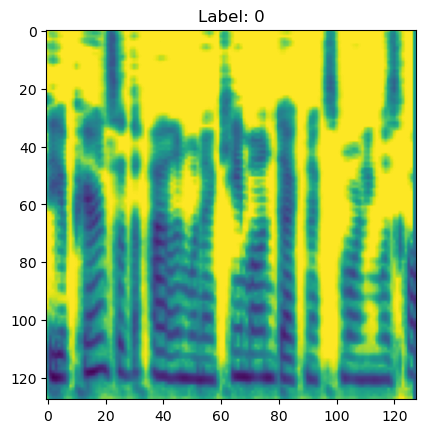

Image shape: torch.Size([1, 128, 128])
Label index: 0


AttributeError: 'MyCustomTransform' object has no attribute '_backward_hooks'

In [5]:
# Basic dataset info
print(len(test_subset))
print("Train Dataset:")
print(f"Number of classes: {len(normalized_train_dataset.classes)}")
print(f"Class names: {normalized_train_dataset.classes}")
print(f"Class to index mapping: {normalized_train_dataset.class_to_idx}")
print(f"Total samples: {len(normalized_train_dataset)}\n")

print("Test Dataset (Noisy):")
print(f"Number of classes: {len(normalized_test_dataset_noisy.classes)}")
print(f"Class names: {normalized_test_dataset_noisy.classes}")
print(f"Class to index mapping: {normalized_test_dataset_noisy.class_to_idx}")
print(f"Total samples: {len(normalized_test_dataset_noisy)}\n")

# print("Transformations applied to the train dataset:")
# print(normalized_train_dataset.transform)

# print("\nTransformations applied to the test dataset:")
# print(normalized_test_dataset_noisy.transform)

from PIL import Image
import matplotlib.pyplot as plt

# Access a sample from the train dataset
image, label = normalized_train_dataset[0]

# Display the image and label
plt.imshow(image.permute(1, 2, 0))  # Permute if it's in CHW format to HWC
plt.title(f"Label: {normalized_train_dataset.classes[label]}")
plt.show()

print(f"Image shape: {image.shape}")  # Tensor shape
print(f"Label index: {label}")

image, label = normalized_test_dataset_noisy[0]

# Display the image and label
plt.imshow(image.permute(1, 2, 0))  # Permute if it's in CHW format to HWC
plt.title(f"Label: {normalized_test_dataset_noisy.classes[label]}")
plt.show()

print(f"Image shape: {image.shape}")  # Tensor shape
print(f"Label index: {label}")


In [ ]:
data_iter = iter(test_loader)  # Create an iterator for the DataLoader
first_batch = next(data_iter)  # Get the first batch

# Unpack the data (images and labels)
images, labels = first_batch

# Display information about the first element
print(f"Images shape: {images.shape}")  # Shape of the batch
print(f"Labels: {labels}")              # Labels for the batch

# If you want to view the first image in the batch
import matplotlib.pyplot as plt

plt.imshow(images[0].permute(1, 2, 0))  # Convert CHW to HWC for matplotlib
plt.title(f"Label: {labels[0]}")
plt.show()

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print("CUDA available:", torch.cuda.is_available())  # Should print True
print("CUDA device count:", torch.cuda.device_count())  # Number of GPUs


cuda
CUDA available: True
CUDA device count: 1


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 60, 5) #*10/ if overfit drop/ one layer + pooling
        self.bn1 = nn.BatchNorm2d(60) # added batch norm
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(60, 160, 3)
        self.bn2 = nn.BatchNorm2d(160) # my bad, it over written first batchnorm
        self.fc1 = nn.Linear(160 * (INPUT_RESOLUTION//4 -2 ) * (INPUT_RESOLUTION//4 - 2), 1200)
        self.fc2 = nn.Linear(1200, 840)
        self.fc3 = nn.Linear(840, 2)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
import torch.optim as optim

LEARNING_RATE = 0.001 # 0.005 standard, trying lwoer for Adam
LR_DECAY = 0.95
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
num_learnable_parameters = sum([
    p.numel() for p in net.parameters() if p.requires_grad
])


In [14]:
import wandb
# wandb.login()
wandb.init(
    project="IML",
    config={
        "learning_rate": LEARNING_RATE,
        # "learning_rate_decay": LR_DECAY,
        "batch_size": train_loader.batch_size,
        "input_resolution": INPUT_RESOLUTION,
        "num_parameters": num_learnable_parameters,
        "architecture": "CNN",
        "dataset": "DAPS"
    }
)

In [16]:
net.to(device)
PRINT_STEP = len(train_loader) // 5 - 1
# Initialize counters
correct_class_0 = 0  
incorrect_class_0 = 0  
correct_class_1 = 0  
incorrect_class_1 = 0 

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

# Counters for total samples in each class
total_class_0 = 0
total_class_1 = 0
print('Starting Training')
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    scaler = torch.GradScaler('cuda') if torch.cuda.is_available() else None    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        #trying mixed precision training for better performance
        if (scaler):
            
            with torch.amp.autocast('cuda'):
                outputs = net(inputs)
                loss = criterion(outputs, labels)# Automatically casts to lower precision
            scaler.scale(loss).backward()  # Scales gradients
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()

        _, predictions = torch.max(outputs.data, 1)
        correct += (predictions == labels).float().mean().item()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_STEP == PRINT_STEP-1: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_STEP:.9f}')

            accuracy = correct / PRINT_STEP
            loss = running_loss / PRINT_STEP
            step = epoch * len(train_loader) + i
            wandb.log({
                    "train/accuracy": accuracy,
                    "train/loss": loss
                },
                step=step
            )
            running_loss = 0.0
            correct = 0

    net.eval()
    test_loss = 0.0
    test_correct = 0
    print("starting testing")
    with torch.no_grad():
        print("no grad")
        for j, data in enumerate(test_loader, 0):
            print("bruh")
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            test_correct += (predictions == labels).float().mean().item()
            
            for label, prediction in zip(labels, predictions):
                if label == 0:
                    total_class_0 += 1
                    if prediction == 0:
                        true_negative += 1
                        correct_class_0 += 1
                    else:
                        incorrect_class_0 += 1  # False Acceptance
                        false_positive += 1
                elif label == 1:
                    total_class_1 += 1
                    if prediction == 1:
                        correct_class_1 += 1
                        true_positive += 1
                    else:
                        incorrect_class_1 += 1  # False Rejection
                        false_negative += 1

    accuracy = test_correct / len(test_loader)
    loss = test_loss / len(test_loader)
    wandb.log({
            "validation/accuracy": accuracy,
            "validation/loss": loss
        },
        step = (epoch + 1) * len(train_loader)
    )
    net.train()
    scheduler.step(test_loss) # test_loss parameter

wandb.finish()

print('Finished Training')

PATH = './net7.pth'
torch.save(net.state_dict(), PATH)

Starting Training


KeyboardInterrupt: 

In [19]:
PATH = './net6.pth'

# Load the trained model
net.to(device)
net.eval()  # Set the model to evaluation mode
net.load_state_dict(torch.load(PATH, weights_only=True))
# Initialize counters
correct_class_0 = 0  
incorrect_class_0 = 0  
correct_class_1 = 0  
incorrect_class_1 = 0 

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

# Counters for total samples in each class
total_class_0 = 0
total_class_1 = 0

test_loss = 0.0
test_correct = 0

def add_gaussian_noise(tensor, mean=0.0, std=0.1):
    noise = torch.randn_like(tensor) * std + mean
    return tensor + noise
    # return torch.clamp(tensor + noise, 0.0, 1.0)

print("starting training")
# Ensure no gradients are computed
with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
        inputs, labels = data

        inputs = add_gaussian_noise(inputs, mean=0.0, std=0.1)

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # Use the same criterion as during training
        test_loss += loss.item()

        _, predictions = torch.max(outputs.data, 1)
        test_correct += (predictions == labels).float().mean().item()
        
        # Class-specific metrics
        for label, prediction in zip(labels, predictions):
            if label == 0:
                total_class_0 += 1
                if prediction == 0:
                    true_negative += 1
                    correct_class_0 += 1
                else:
                    incorrect_class_0 += 1  # False Positive
                    false_positive += 1
            elif label == 1:
                total_class_1 += 1
                if prediction == 1:
                    correct_class_1 += 1
                    true_positive += 1
                else:
                    incorrect_class_1 += 1  # False Negative
                    false_negative += 1

# Calculate metrics
accuracy = test_correct / len(test_loader)
average_loss = test_loss / len(test_loader)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Average Test Loss: {average_loss:.4f}")

# Class-wise metrics
print(f"Class 0: Correct: {correct_class_0}, Incorrect: {incorrect_class_0}, Total: {total_class_0}")
print(f"Class 1: Correct: {correct_class_1}, Incorrect: {incorrect_class_1}, Total: {total_class_1}")

# Confusion matrix metrics
print(f"True Positives: {true_positive}")
print(f"False Positives: {false_positive}")
print(f"True Negatives: {true_negative}")
print(f"False Negatives: {false_negative}")


starting training
Test Accuracy: 52.06%
Average Test Loss: 9.1815
Class 0: Correct: 246, Incorrect: 7363, Total: 7609
Class 1: Correct: 7705, Incorrect: 0, Total: 7705
True Positives: 7705
False Positives: 7363
True Negatives: 246
False Negatives: 0


In [42]:
if total_class_0 > 0:
    far = incorrect_class_0 / total_class_0
else:
    far = None  # handle division by zero if there are no samples for Class 0

if total_class_1 > 0:
    frr = incorrect_class_1 / total_class_1
else:
    frr = None  # handle division by zero if there are no samples for Class 1
#Try torch metrics for cleaner code
print(f"False Acceptance Ratio (FAR): {far:.2%}")
print(f"False Rejection Ratio (FRR): {frr:.2%}")
print(f"Sensitivity : {true_positive/(true_positive+false_negative):.2%}")
print(f"Specificity : {true_negative/(true_negative+false_positive):.2%}")
print(f"Precision : {true_positive/(true_positive+false_positive):.2%}")
print(f"Accuracy : {(true_positive+true_negative)/(true_positive+false_positive+true_negative+false_negative):.2%}")
print(f"Negative Predict Value : {true_positive/(true_negative+false_negative):.2%}")
# print(f": : {}")

print(f"F-1 score: : {2*true_positive/(2*true_positive+false_positive+false_negative):.2%}")


print(f'Accuracy of the network on the test images: {100 * (correct_class_0+correct_class_1) // (total_class_0+total_class_1)} %')

False Acceptance Ratio (FAR): 2.88%
False Rejection Ratio (FRR): 3.55%
Sensitivity : 96.45%
Specificity : 97.12%
Precision : 97.13%
Accuracy : 96.78%
Negative Predict Value : 96.97%
F-1 score: : 96.79%
Accuracy of the network on the test images: 96 %
